# Interactive visualization of topographic maps

This interactive notebook allows for interactive visualization of polar angle, polar angle gradients, and visual field sign maps as a function of the participant’s assignment to the reported clusters. 

## General settings

In [1]:
import numpy as np
import pandas as pd
import random
import sys

sys.path.append('../')

from figures.polarAngle_maps import polarAngle_plot
from functions.gradientAnalysis import PA_gradients, fieldSign
from ipywidgets import interact, Dropdown

In [5]:
# All individuals
with open('./../list_subj.txt') as fp:
    subjects = fp.read().split("\n")
list_of_subs = np.array(subjects[0:len(subjects) - 1])

# Cluster assignment
cluster_assignment = np.load('./../output/clusters_individualIndeces_PA.npz')['list']

clusters = {}
for i in np.unique(cluster_assignment):
    clusters['cluster_' + str(i + 1)] = list(list_of_subs[cluster_assignment == i])

## Cluster assignment

Here is an interactive visualization function for visually inspecting left hemisphere polar angle maps in early visual cortex. Note that for the interactive visualization to behave appropriately, i.e., updating the list of indices given the cluster choice, you should run the cell containing the plotting function should be last to be run.

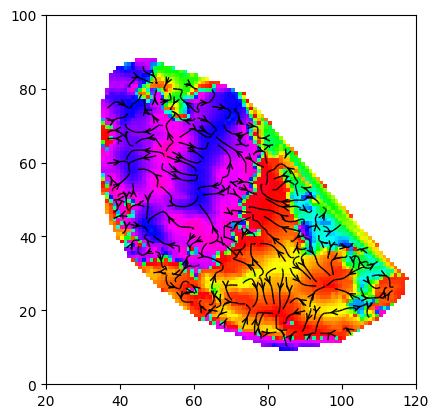

/tmp/ipykernel_272782/3765257981.py:211: RuntimeWarning: invalid value encountered in divide
  theta = np.arccos(dot_product/(modulus_PA*modulus_ecc))


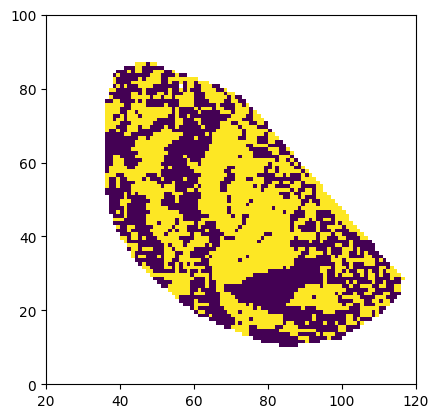

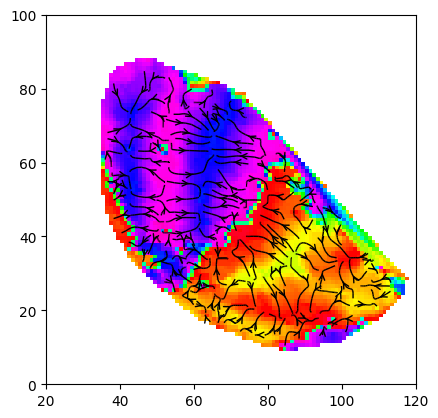

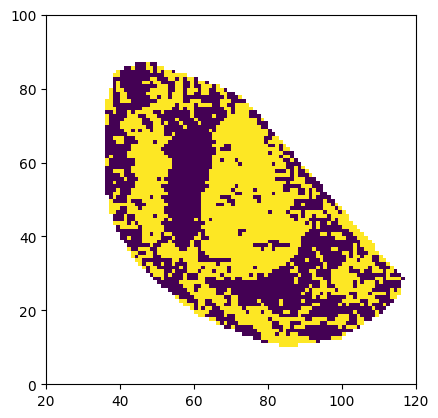

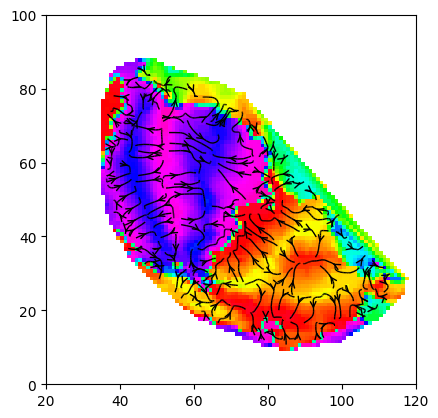

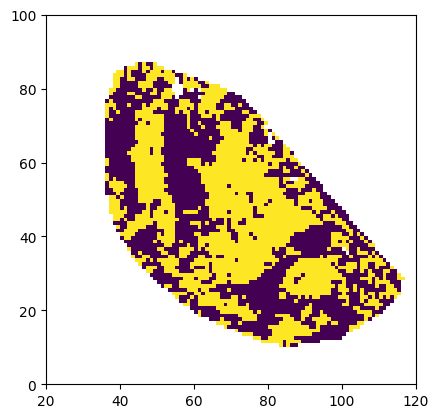

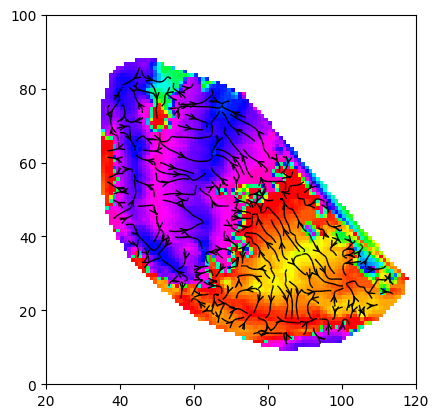

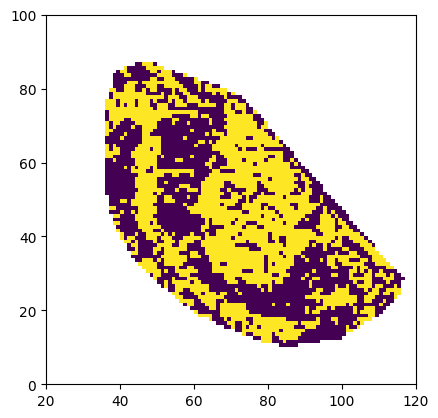

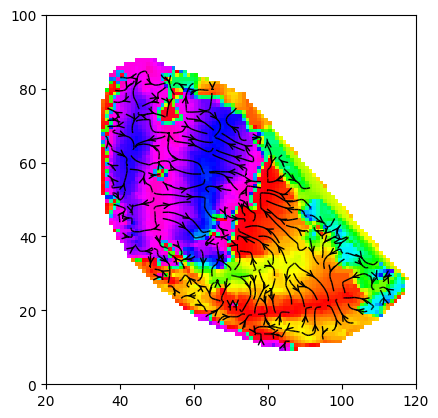

/tmp/ipykernel_272782/3765257981.py:211: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(dot_product/(modulus_PA*modulus_ecc))


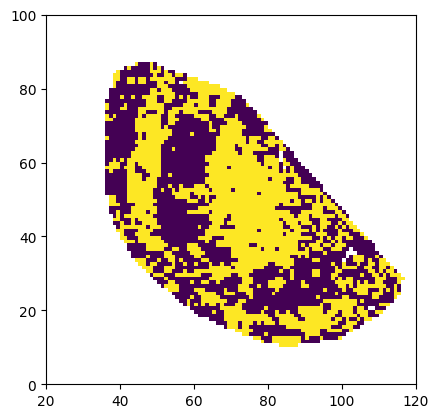

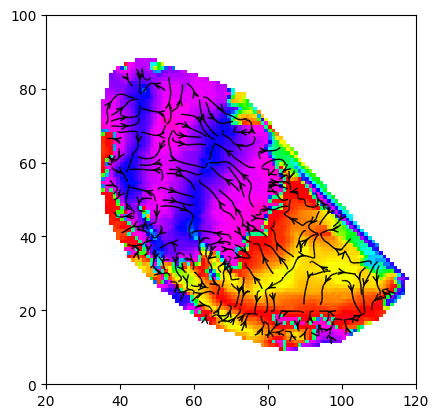

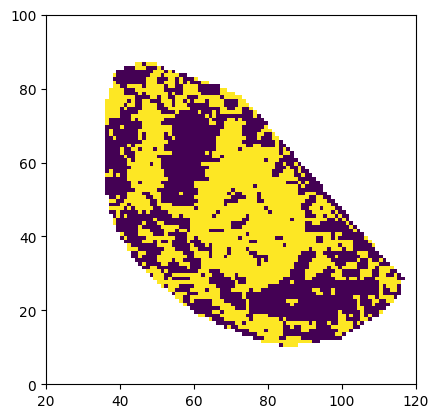

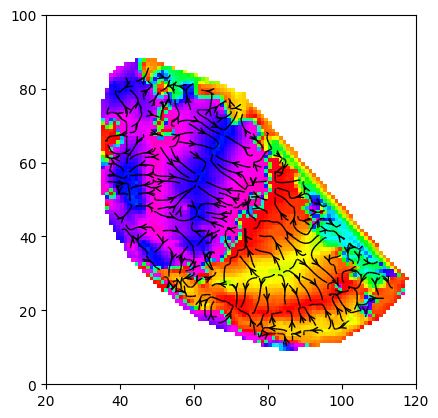

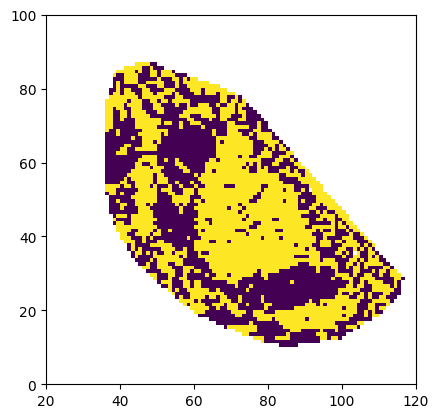

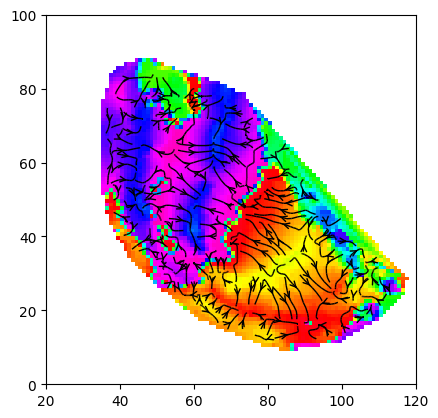

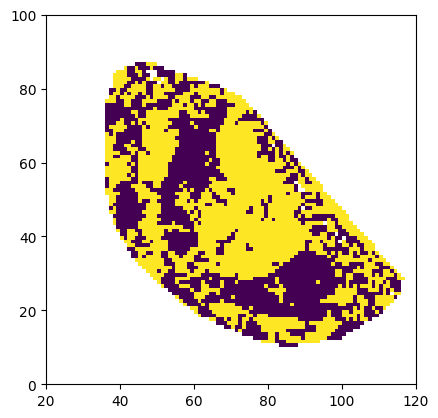

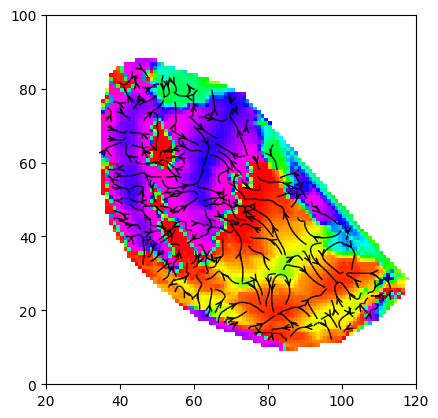

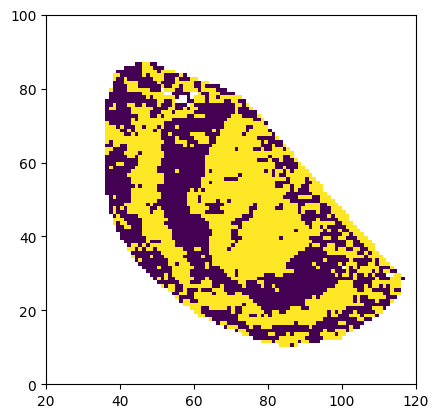

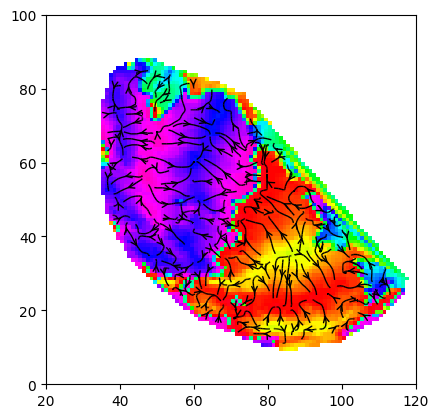

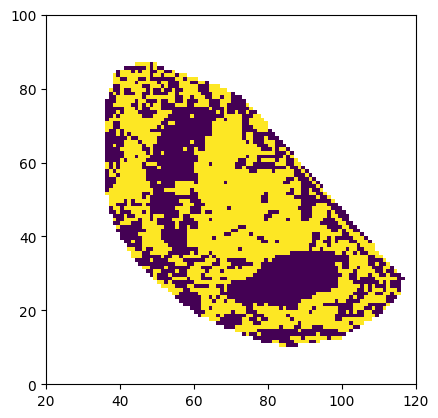

interactive(children=(Dropdown(description='cluster', options=('cluster_1', 'cluster_2', 'cluster_3', 'cluster…

In [6]:
cluster_index = Dropdown(options = clusters.keys())
subject_index= Dropdown()
import os.path as osp
import sys
import numpy as np
import os.path as osp
import sys
import time
import matplotlib.pyplot as plt
import scipy
import nibabel as nib
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata

sys.path.append('..')


from functions.def_ROIs_EarlyVisualAreas import roi
from functions.def_ROIs_DorsalEarlyVisualCortex import roi as ROI
from functions.individual_variability import grab_data

def PA_gradients(subject_id, path, plot_type = 'streamplot', binarize = False, dorsal_only=True, save = False, save_path = None):
    """
    Plot the polar angle gradient for the dorsal portion of the early visual cortex.
    Parameters
    ----------
    subject_id : int
        Subject ID.
    path : str
        Path to the data.
    plot_type : str, optional
        Type of plot. The default is 'streamplot'.
    binarize : bool, optional
        Binarize the polar angle map. The default is False.
    dorsal_only : bool, optional
        Plot only the dorsal portion of the early visual cortex. The default is True.
    save : bool, optional
        Save the figure. The default is False.
    save_path : str, optional
        Path to save the figure. The default is None.
    Returns
    -------
    Plot of the polar angle gradient.   
    """

    # Early visual cortex
    label_primary_visual_areas = ['ROI']
    final_mask_L, final_mask_R, index_L_mask, index_R_mask = roi(
        label_primary_visual_areas)

    # Dorsal portion
    label_primary_visual_areas = ['ROI']
    final_mask_L_dorsal, final_mask_R_dorsal, index_L_mask_dorsal, index_R_mask_dorsal = ROI(
        label_primary_visual_areas)
    if dorsal_only ==False:
        final_mask_L_dorsal = np.ones(np.shape(final_mask_L_dorsal))
    # Number of nodes
    number_cortical_nodes = int(64984)
    number_hemi_nodes = int(number_cortical_nodes / 2)

    # Loading the flat surface
    flat_surf = nib.load(osp.join(path,'S1200_7T_Retinotopy181.L.sphere.32k_fs_LR.surf.gii'))
    flat_surf_pos = flat_surf.agg_data('pointset')[final_mask_L*final_mask_L_dorsal==1]
    coord_plane = np.array(flat_surf_pos.T[0:3,].T).astype(int)
    new_coord_plane = np.matmul([[0, 0, 1],[0, 1, 0]], coord_plane.T).T + 100
    
    # Loading polar angle values
    z_values = np.zeros((number_hemi_nodes, 1))
    data = scipy.io.loadmat(osp.join(path, 'cifti_polarAngle_all.mat'))[
            'cifti_polarAngle']
    z_values[final_mask_L*final_mask_L_dorsal == 1] = np.reshape(
                data['x' + str(subject_id) + '_fit1_polarangle_msmall'][0][0][
                    0:number_hemi_nodes].reshape(
                        (number_hemi_nodes))[final_mask_L*final_mask_L_dorsal == 1], (-1, 1))
    z_values[final_mask_L*final_mask_L_dorsal != 1] = 0

    # Interpolating the polar angle values
    grid_x, grid_y = np.mgrid[40:120, 0:60]
    if dorsal_only == False:
        grid_x, grid_y = np.mgrid[20:120, 0:100]
    grid_z0 = griddata(new_coord_plane, z_values[final_mask_L*final_mask_L_dorsal == 1], (grid_x, grid_y), method='linear')

    # Determining the gradient
    dx, dy = np.gradient(grid_z0[:,:,0])

    # Binarizing the polar angle map
    if binarize == True:
        z_values[(z_values >= 0) & (z_values <= 45)] = 0
        z_values[(z_values > 45) & (z_values <= 180)]= 90
        z_values[(z_values >= 315) & (z_values <= 360)] = 360
        z_values[(z_values > 180) & (z_values < 315)] = 270
        z_values[final_mask_L*final_mask_L_dorsal != 1] = 0
        grid_z0 = griddata(new_coord_plane, z_values[final_mask_L*final_mask_L_dorsal == 1], (grid_x, grid_y), method='linear')

    # Sampling the gradient
    X = grid_x[::2, ::2]
    Y = grid_y[::2, ::2]
    U = dx[::2, ::2]
    V = dy[::2, ::2]

    # Plotting the gradient
    if dorsal_only == True:
        plt.imshow(grid_z0[:,:,0].T, extent=[40,120, 0,60], origin='lower', cmap='gist_rainbow_r', vmax = 361)
    if dorsal_only == False:
        plt.imshow(grid_z0[:,:,0].T, extent=[20,120, 0,100], origin='lower', cmap='gist_rainbow_r', vmax = 361)
    if plot_type == 'streamplot':
        plt.streamplot(X.T, Y.T, U.T, V.T,density = 2, linewidth=1, arrowsize=1, arrowstyle='->', color='k')
    elif plot_type == 'quiver':
        plt.quiver(X, Y, U, V,scale = 10, units = 'x')

    if save == True:
        plt.savefig(osp.join(save_path, 'PA_gradients_' + str(subject_id)  + '.png'))
    return plt.show()

def fieldSign(subject_id, path, dorsal_only=True, smoothing = False, save = False, save_path = None):
    """
    Plot the field sign for the dorsal portion of the early visual cortex.
    Parameters
    ----------
    subject_id : int
        Subject ID.
    path : str
        Path to the data.
    dorsal_only : bool, optional
        Plot the dorsal portion only. The default is True.
    smoothing : bool, optional
        Smooth the polar angle interpolation. The default is False.
    save : bool, optional
        Save the figure. The default is False.
    save_path : str, optional
        Path to save the figure. The default is None.
    Returns
    -------
    Plot of the field sign. 
    """

    # Early visual cortex
    label_primary_visual_areas = ['ROI']
    final_mask_L, final_mask_R, index_L_mask, index_R_mask = roi(
        label_primary_visual_areas)

    # Dorsal portion
    label_primary_visual_areas = ['ROI']
    final_mask_L_dorsal, final_mask_R_dorsal, index_L_mask_dorsal, index_R_mask_dorsal = ROI(
        label_primary_visual_areas)
    if dorsal_only ==False:
        final_mask_L_dorsal = np.ones(np.shape(final_mask_L_dorsal))
    # Number of nodes
    number_cortical_nodes = int(64984)
    number_hemi_nodes = int(number_cortical_nodes / 2)

    # Loading the flat surface
    flat_surf = nib.load(osp.join(path,'S1200_7T_Retinotopy181.L.sphere.32k_fs_LR.surf.gii'))
    flat_surf_pos = flat_surf.agg_data('pointset')[final_mask_L*final_mask_L_dorsal==1]
    coord_plane = np.array(flat_surf_pos.T[0:3,].T).astype(int)
    new_coord_plane = np.matmul([[0, 0, 1],[0, 1, 0]], coord_plane.T).T + 100


    #### Polar angle map ####
    # Loading polar angle values
    z_values_PA = np.zeros((number_hemi_nodes, 1))
    data = scipy.io.loadmat(osp.join(path, 'cifti_polarAngle_all.mat'))[
            'cifti_polarAngle']
    z_values_PA[final_mask_L*final_mask_L_dorsal == 1] = np.reshape(
                data['x' + str(subject_id) + '_fit1_polarangle_msmall'][0][0][
                    0:number_hemi_nodes].reshape(
                        (number_hemi_nodes))[final_mask_L*final_mask_L_dorsal == 1], (-1, 1))
    # Shifting PA values
    sum = z_values_PA < 180
    minus = z_values_PA > 180
    z_values_PA[sum] = z_values_PA[sum] + 180
    z_values_PA[minus] = z_values_PA[minus] - 180

    z_values_PA[final_mask_L*final_mask_L_dorsal != 1] = 0

    # Interpolating the polar angle values
    grid_x, grid_y = np.mgrid[40:120, 0:60]
    if dorsal_only == False:
        grid_x, grid_y = np.mgrid[20:120, 0:100]
    grid_z0_PA = griddata(new_coord_plane, z_values_PA[final_mask_L*final_mask_L_dorsal == 1], (grid_x, grid_y), method='linear')

    # Smoothing the polar angle map
    if smoothing == True:
        grid_z0_PA[:,:,0] = gaussian_filter(grid_z0_PA[:,:,0], sigma=.8)
    
    # Determining the gradient
    dx_PA, dy_PA = np.gradient(grid_z0_PA[:,:,0])

    #### Eccentricity map ####
    # Loading eccentricity values
    z_values_ecc = np.zeros((number_hemi_nodes, 1))
    data = scipy.io.loadmat(osp.join(path, 'cifti_eccentricity_all.mat'))[
            'cifti_eccentricity']
    z_values_ecc[final_mask_L*final_mask_L_dorsal == 1] = np.reshape(
                data['x' + str(subject_id) + '_fit1_eccentricity_msmall'][0][0][
                    0:number_hemi_nodes].reshape(
                        (number_hemi_nodes))[final_mask_L*final_mask_L_dorsal == 1], (-1, 1))
    z_values_ecc[final_mask_L*final_mask_L_dorsal != 1] = 0

    # Interpolating the eccentricity values
    grid_z0_ecc = griddata(new_coord_plane, z_values_ecc[final_mask_L*final_mask_L_dorsal == 1], (grid_x, grid_y), method='linear')

    # Determining the gradient
    dx_ecc, dy_ecc = np.gradient(grid_z0_ecc[:,:,0])

    #### Field sign analysis ####
    # Angle between gradient vectors
    dot_product = dx_PA*dx_ecc + dy_PA*dy_ecc
    modulus_PA = np.sqrt(dx_PA**2 + dy_PA**2)
    modulus_ecc = np.sqrt(dx_ecc**2 + dy_ecc**2)
    theta = np.arccos(dot_product/(modulus_PA*modulus_ecc))
    
    # Cross product
    cross_product = dx_PA*dy_ecc - dy_PA*dx_ecc

    # Binarizing
    theta[cross_product<0] = 2*np.pi - theta[cross_product<0]
    theta[theta>np.pi] = 2*np.pi
    theta[theta<np.pi] = np.pi

    # Plotting the visual field sign
    if dorsal_only == True:
        plt.imshow(theta[:,:].T, extent=[40,120, 0,60], origin='lower', cmap='viridis')
    if dorsal_only == False:
        plt.imshow(theta[:,:].T, extent=[20,120, 0,100], origin='lower', cmap='viridis')
    if save == True:
        if smoothing==False:
            plt.savefig(osp.join(save_path, 'fieldSign_' + str(subject_id)  + '.png'))
        else:
            plt.savefig(osp.join(save_path, 'fieldSign_' + str(subject_id)  + '_smoothed.png'))
    return plt.show()



if __name__ == '__main__':
    subjects = [397760, 926862, 105923, 114823, 198653, 789373] # Figure 7
    subjects = [249947, 525541, 169747, 826353, 192641, 126426, 401422, 177140, 135124, 130114] # Supplementary Figure 11
    # with open('./../list_subj.txt') as fp:
    #     subjects = fp.read().split("\n")
    # subjects = np.array(subjects[0:len(subjects) - 1])
    for subject_id in subjects:
        path = './../data'
        PA_gradients(subject_id, path, plot_type = 'streamplot', dorsal_only = False, save=True, save_path = './../figures')
        fieldSign(subject_id, path, save=True, dorsal_only=False,  save_path = './../figures')
dorsal_roi = Dropdown(options = [False, True])
binarize = Dropdown(options = [False, True])

@interact(cluster = cluster_index, index = subject_index, dorsal_roi = dorsal_roi, binarize = binarize)
def plot1(cluster, index, dorsal_roi, binarize):
    subject_index.options = clusters[cluster]
    print('Number of participants in this cluster: ' + str(len(subject_index.options)))
    if index == None:
        return 'Select a cluster and a subject'
    else:
        return polarAngle_plot(index, './../data', dorsal_only = dorsal_roi, binarize = binarize)

To generate the average maps from each cluster, you may uncomment and run the following cell.

In [3]:
# %%bash
# cd ./../figures/
# python mode_PA_DorsalEarlyVisualCortex_maps.py --binarize True

To generate the average maps shown in in Supplementary Figure 3, you may uncomment and run the following cell.

In [2]:
# %%bash
# cd ./../functions/
# python clustering.py

In [1]:
# %%bash
# cd ./../figures/
# python mode_PA_meanMaps.py --hemisphere 'RH' --modality 'polarAngle'

# Streamline plot of polar angle gradients

Here is an interactive visualization function for visually inspecting polar angle gradients in early visual cortex. Note that these plots have a different orientation from the previous one, but they are colored the same way.

In [4]:
cluster_index = Dropdown(options = clusters.keys())
subject_index= Dropdown()
dorsal_roi = Dropdown(options = [False, True])
binarize = Dropdown(options = [False, True])
plot_type = Dropdown(options = ['streamplot', 'quiver'])


@interact(cluster = cluster_index, index = subject_index, dorsal_roi=dorsal_roi, binarize = binarize , plot_type = plot_type)
def plot2(cluster, index, dorsal_roi, plot_type, binarize):
    subject_index.options = clusters[cluster]
    if index == None:
        return 'Select a cluster and a subject'
    else:
        return PA_gradients(index, './../data', plot_type = plot_type, binarize = binarize, dorsal_only=dorsal_roi)

interactive(children=(Dropdown(description='cluster', options=('cluster_1', 'cluster_2', 'cluster_3', 'cluster…

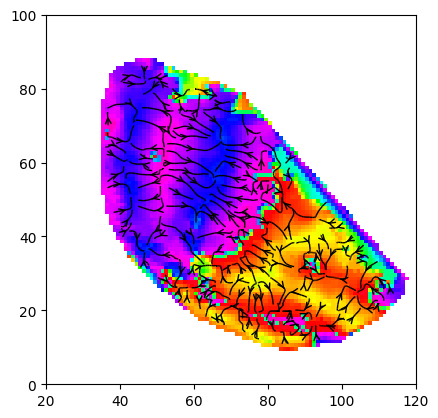

In [15]:
# check
PA_gradients('581450', './../data', dorsal_only=False)

# Visual field sign analysis

Here is an interactive visualization function for visually inspecting visual field signs in early visual cortex.

In [5]:
cluster_index = Dropdown(options = clusters.keys())
subject_index= Dropdown()
dorsal_roi = Dropdown(options = [False, True])


@interact(cluster = cluster_index, index = subject_index, dorsal_roi = dorsal_roi)
def plot3(cluster, index, dorsal_roi):
    subject_index.options = clusters[cluster]
    if index == None:
        return 'Select a cluster and a subject'
    else:
        return fieldSign(index, path='./../data', dorsal_only=dorsal_roi)

interactive(children=(Dropdown(description='cluster', options=('cluster_1', 'cluster_2', 'cluster_3', 'cluster…

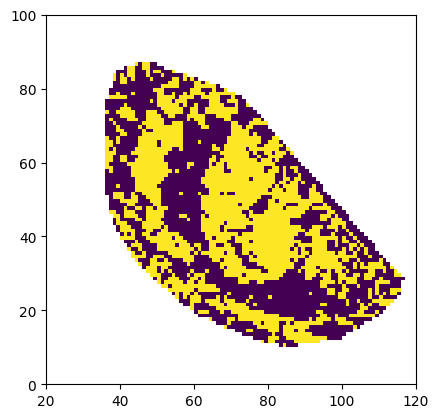

In [7]:
# check
fieldSign('146735', './../data', dorsal_only=False)

In [ ]:
# # Random sample for Supplementary Figure 3, 5, 6, 7, 8
# random.seed('123')
# random.sample(clusters['cluster_6'],9)